# Indian start-up ecosystem

Your team is trying to venture into the Indian start-up ecosystem. As the data expert of the team, you are to investigate the ecosystem and propose the best course of action.
Analyze funding received by start-ups in India from 2018 to 2021.
Separate data for each year of funding will be provided.
• In these datasets, you'll find the start-ups' details, the funding amounts received, and the investors' information

In [219]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import f_oneway
import statistics as stat
import warnings
import os

warnings.filterwarnings('ignore')

In [220]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [221]:
conn_str =f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [222]:
connection = pyodbc.connect(conn_str)

query1 = "Select * from LP1_startup_funding2020"
data2020 = pd.read_sql(query1, connection)

query2 = "Select * from LP1_startup_funding2021"
data2021 = pd.read_sql(query2, connection)

In [223]:
df2018 = pd.read_csv('startup_funding2018.csv')

df2019 = pd.read_csv('startup_funding2019.csv')

# STEP 1

In [ ]:
# Add a Year Colunm

In [224]:
df2018['Year']='2018'
df2019['Year']='2019'
data2020['Year']='2020'
data2021['Year']='2021'

# STEP 2

Clean and Concat the 2 csv file 2018&2019

In [225]:
# Drop the Colunms You see no use keeping

df2019.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)
data2020.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)
data2021.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)

In [226]:
# Select specific columns and rename them

df2018 = df2018.rename(columns={'Company Name': 'Company_Brand', 'Round/Series': 'Stage', 'Industry': 'Sector', 'Amount': 'Amount', 'About Company': 'BIO', 'Location':'HeadQuarter'})
df2019 = df2019.rename(columns={'Company/Brand': 'Company_Brand', 'Sector': 'Sector', 'Stage': 'Stage', 'Amount($)': 'Amount', 'What it does': 'BIO', 'HeadQuarter':'HeadQuarter'})


# STEP 3

Currency Convertion 

In [227]:
# Merge the two csv files 

df18_19 = pd.concat([df2018, df2019], ignore_index=True)

In [228]:
# Create a new column 'currency' based on currency symbols

df18_19['currency'] = df18_19['Amount'].apply(lambda x: 'INR' if '₹' in x else ('USD' if '$' in x else 'USD'))

In [229]:
# Create columns 'amount_inr' and 'amount_usd'

df18_19['amount_inr'] = df18_19.apply(lambda row: row['Amount'] if row['currency'] == 'INR' else 0, axis=1)
df18_19['amount_usd'] = df18_19.apply(lambda row: row['Amount'] if row['currency'] == 'USD' else 0, axis=1)

In [230]:
# Remove the currency sysmbols and the commas 

df18_19['amount_inr'] = df18_19['amount_inr'].str.replace('₹', '').str.replace('$', '').str.replace(',', '')
df18_19['amount_usd'] = df18_19['amount_usd'].str.replace('₹', '').str.replace('$', '').str.replace(',', '')

In [231]:
# Replace 'Undisclosed' values with NaN

df18_19['amount_inr'] = df18_19['amount_inr'].replace('Undisclosed', np.nan, regex=True)
df18_19['amount_usd'] = df18_19['amount_usd'].replace('Undisclosed', np.nan, regex=True)

In [232]:
# Convert the object values into numeric values for calculation

df18_19['amount_inr'] = pd.to_numeric(df18_19['amount_inr'], errors='coerce')
df18_19['amount_usd'] = pd.to_numeric(df18_19['amount_usd'], errors='coerce')

In [233]:
# Define the exchange rate
exchange_rate_inr_to_usd = 1 / 83.23  # 1 USD = 83.23 INR

# Convert 'amount_inr' to USD
df18_19['amount_inr'] = df18_19['amount_inr'].apply(lambda x: x * exchange_rate_inr_to_usd if x is not None else None)

In [234]:
# Create a new column 'Updated_Amount' by filling missing values in 'amount_inr' with 'amount_usd'
df18_19['Updated_Amount'] = df18_19['amount_inr'].fillna(df18_19['amount_usd'])

# STEP 4

Clean and Concat the 2 sql file 2020&2021

In [235]:
# Renaming the Column

data2020 = data2020.rename(columns={'Company_Brand': 'Company_Brand', 'Sector': 'Sector', 'Amount': 'Amount', 'What_it_does': 'BIO', 'Location':'HeadQuarter'})
data2021 = data2021.rename(columns={'Company_Brand': 'Company_Brand', 'Sector': 'Sector', 'Amount': 'Amount', 'What_it_does': 'BIO', 'HeadQuarter':'HeadQuarter'})

In [236]:
# Drop a specific column in place

data2020.drop(columns=['column10'], inplace=True)


# STEP 5

Currency Convertion 

In [237]:
# Merge the two sql files 

df20_21 = pd.concat([data2020, data2021], ignore_index=True)

In [238]:
# Create a new column 'Updated_Amount' by filling missing values in 'amount_inr' with 'amount_usd'

df20_21['Updated_Amount'] = df20_21['Amount']

In [239]:
# Create a column 'with_$' for values with '$' sign and 'without_$' for values without '$'

df20_21['with_$'] = df20_21['Updated_Amount'].apply(lambda x: x if '$' in str(x) else None)
df20_21['without_$'] = df20_21['Updated_Amount'].apply(lambda x: x if '$' not in str(x) else None)


In [240]:
# Remove the currency sysmbols and the commas 

df20_21['with_$'] = df20_21['with_$'].str.replace('$', '')


In [241]:
# Replace 'Undisclosed' values with NaN

df20_21['with_$'] = df20_21['with_$'].replace('Undisclosed', np.nan, regex=True)

In [242]:
# Convert the object values into numeric values for calculation

df20_21['with_$'] = pd.to_numeric(df20_21['with_$'], errors='coerce')
df20_21['without_$'] = pd.to_numeric(df20_21['without_$'], errors='coerce')

In [243]:
# Merge the two Colunms into a new colunm 

df20_21['Updated_Amount'] = df20_21['without_$'].fillna(df20_21['with_$'])

In [249]:
df20_21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company_Brand   2264 non-null   object 
 1   HeadQuarter     2169 non-null   object 
 2   Sector          2251 non-null   object 
 3   BIO             2264 non-null   object 
 4   Amount          2007 non-null   object 
 5   Stage           1372 non-null   object 
 6   Year            2264 non-null   object 
 7   Updated_Amount  1514 non-null   float64
dtypes: float64(1), object(7)
memory usage: 141.6+ KB


In [248]:
df18_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company_Brand   615 non-null    object 
 1   Sector          610 non-null    object 
 2   Stage           569 non-null    object 
 3   Amount          615 non-null    object 
 4   HeadQuarter     596 non-null    object 
 5   BIO             615 non-null    object 
 6   Year            615 non-null    object 
 7   Updated_Amount  455 non-null    float64
dtypes: float64(1), object(7)
memory usage: 38.6+ KB


# Merging All the Files 

In [247]:
df18_19.drop(['amount_usd', 'amount_inr', 'currency'], axis=1, inplace=True)
df20_21.drop(['without_$', 'with_$'], axis=1, inplace=True)


In [284]:
india_startup_df = pd.concat([df18_19, df20_21], ignore_index=True)

In [286]:

# Fill missing values in the specific column with 0.0
india_startup_df['Updated_Amount'].fillna(0.0, inplace=True)
india_startup_df['Amount'].fillna(0.0, inplace=True)



In [288]:
# Fill missing values in  with "unknown"
india_startup_df.fillna("unknown", inplace=True)

Null Hypothesis: 

The total funding received by Indian startups has been increasing over the years (from 2018 to 2021).

Explanation: This hypothesis focuses on the trend in total funding over time. 

Calculate the total funding received by all startups for each year (2018, 2019, 2020, 2021).
Create a time series plot or line chart to visualize the funding trend over the four years.

In [289]:
india_startup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2879 entries, 0 to 2878
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company_Brand   2879 non-null   object 
 1   Sector          2879 non-null   object 
 2   Stage           2879 non-null   object 
 3   Amount          2879 non-null   object 
 4   HeadQuarter     2879 non-null   object 
 5   BIO             2879 non-null   object 
 6   Year            2879 non-null   object 
 7   Updated_Amount  2879 non-null   float64
dtypes: float64(1), object(7)
memory usage: 180.1+ KB


In [290]:
# Calculate the count of missing values in a specific column
missing_values_count = india_startup_df['Updated_Amount'].isna()
missing_values_count


0       False
1       False
2       False
3       False
4       False
        ...  
2874    False
2875    False
2876    False
2877    False
2878    False
Name: Updated_Amount, Length: 2879, dtype: bool

In [294]:
# Get the Sum

total_funding = india_startup_df.groupby('Year')['Updated_Amount'].mean()

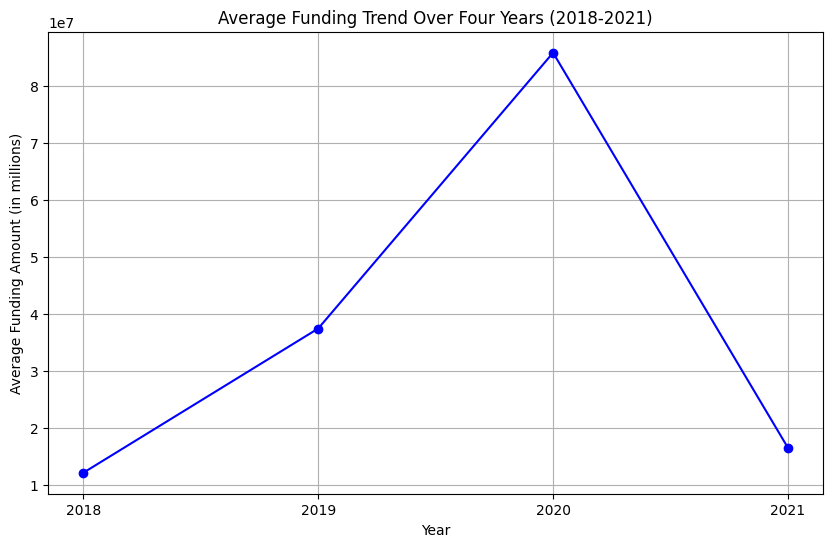

In [296]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(total_funding.index, total_funding.values, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average Funding Amount (in millions)')
plt.title('Average Funding Trend Over Four Years (2018-2021)')
plt.grid(True)
plt.show()

Null Hypothesis:

The headquarters location of a startup in India (e.g., Chennai, Bangalore, Pune, New Delhi, Indore) has an impact on the funding amount it receives.

Explanation: 
The location of a startup's headquarters may influence its access to funding. For example, we might expect that startups in major startup hubs like Bangalore receive larger amounts of funding compared to those in smaller cities. 

ANOVA or Kruskal-Wallis Test: To determine if there are significant differences in funding amounts between startups in different cities.


In [297]:


# Extract unique locations from the 'HeadQuarter' 
locations = india_startup_df['HeadQuarter'].unique()

# Groupy data by headquarter
groups = [india_startup_df[india_startup_df['HeadQuarter'] == location ]['Updated_Amount']
for location in locations]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*groups)

# Check the p-value to determine statistical significance
if p_value < 0.05:
    print("There is a significant difference in funding amounts between cities.")
else:
    print("There is no significant difference in funding amounts between cities.")


There is no significant difference in funding amounts between cities.


# Analytic Question

1.)Trend Analysis: Is there a noticeable trend in the total funding received by Indian startups from 2018 to 2021? Are the funding amounts increasing or decreasing over the years?

2.)Sector Analysis: Which sector received the highest average funding in 2019, and has it changed in 2020 and 2021? Are there sectors that consistently attract more funding over the years?

3.)Location Impact: Do startups headquartered in specific cities or regions (e.g., Bangalore, Mumbai, Chennai) tend to receive more funding on average? Is there a correlation between the location of a startup and its funding amount?

4.)Stage of Funding: Are there significant differences in average funding amounts based on the funding stage (e.g., Seed, Series A, Series D) of the startups? How does the stage of funding impact the funding received by startups?

5.)Correlation between Sectors and Funding Stages: Is there a relationship between the sector of a startup and its funding stage? For example, do startups in the EdTech sector tend to receive more funding at a specific stage compared to startups in other sectors?
